In [18]:
import os 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
from sklearn.inspection import plot_partial_dependence


from tpot import TPOTRegressor
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import pymc3 as pm
import arviz as az

import voteestimator
import top2000analysis

In [3]:
FOLDER_DATA = os.path.join('..', 'Data')

# Splitting into train and test set

In [4]:
a = top2000analysis.AnalysisSetCreator()

df_song = a.create_analysis_set(FOLDER_DATA)
df_artist = a.create_artist_set(FOLDER_DATA)
df = a.create_full_feature_set(FOLDER_DATA)

In [5]:
features = ['JarenGeleden',
 'YearMadeSong',
 'AgePassingArtist',
 'NrArtists',
 'PctVotesBeforeDeathSong',
 'NrsBeforeDeath',
 'PopularityWithinArtist',
'LogSongPopularityWithinArtist',
'DaysToStemperiode',
 'LogPopularity',
 'IsDutchArtist'
]

In [6]:
X = df[features].assign(IsDutchArtist = lambda df: df['IsDutchArtist'].astype(int))
# X_train, X_test, y_train, y_test = train_test_split(X, df['LogBoost'], random_state=123)

In [7]:
df['JarenGeleden'].value_counts(normalize=True).sort_index().cumsum()

-19.0    0.032680
-18.0    0.071895
-17.0    0.124183
-16.0    0.202614
-15.0    0.215686
-14.0    0.235294
-13.0    0.274510
-11.0    0.405229
-9.0     0.437908
-8.0     0.477124
-7.0     0.503268
-5.0     0.601307
-4.0     0.803922
-3.0     0.882353
-2.0     0.960784
 0.0     1.000000
Name: JarenGeleden, dtype: float64

In [8]:
def split_train_test(X, y, jaren_geleden_split=-4):
    train_set = X['JarenGeleden'].le(jaren_geleden_split)
    X_train = X[train_set].copy()
    y_train = y[train_set].copy()
    X_test = X[~train_set].copy()
    y_test = y[~train_set].copy()
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = split_train_test(X, df['LogBoost'])

In [9]:
df_train, df_test, y_train, y_test = split_train_test(df, df['LogBoost'])

# Calculating the baseline: Dummy Classifier

In [10]:
dummy = sklearn.dummy.DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [11]:
y_pred_train = dummy.predict(X_train)
sklearn.metrics.mean_absolute_error(y_train, y_pred_train)

0.47021278302797437

In [12]:
y_pred = dummy.predict(X_test)
sklearn.metrics.mean_absolute_error(y_test, y_pred)

0.4163449458411951

In [13]:
DUMMY_SCORE = sklearn.metrics.mean_absolute_error(y_test, y_pred)
model_results = {}

# Fitting different models

## Full-out modelling: TPOT

In [61]:
logo = sklearn.model_selection.GroupKFold().split(X=X_train, y=y_train, groups=X_train['JarenGeleden'])
logo = list(logo)

In [62]:
tpot = TPOTRegressor(
    random_state=123,
    verbosity=2,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    template='Transformer-Selector-Regressor',
    warm_start=True,
    memory='auto',
    early_stop=10,
#     cv=sklearn.model_selection.TimeSeriesSplit(),
    cv=logo,
)
tpot.fit(X_train, y_train)


Generation 1 - Current best internal CV score: -0.39329102538337996

Generation 2 - Current best internal CV score: -0.3928461002930354

Generation 3 - Current best internal CV score: -0.39267217429755397

Generation 4 - Current best internal CV score: -0.39267217429755397

Generation 5 - Current best internal CV score: -0.3894107550833462

Generation 6 - Current best internal CV score: -0.38799024949147704

Generation 7 - Current best internal CV score: -0.38799024949147704

Generation 8 - Current best internal CV score: -0.38344044212908823

Generation 9 - Current best internal CV score: -0.38189021003249357

Generation 10 - Current best internal CV score: -0.38189021003249357

Generation 11 - Current best internal CV score: -0.38189021003249357

Generation 12 - Current best internal CV score: -0.38189021003249357

Generation 13 - Current best internal CV score: -0.38189021003249357

Generation 14 - Current best internal CV score: -0.3790468012183902

Generation 15 - Current best in

TPOTRegressor(cv=[(array([ 24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  65,
        66,  67,  68,  69,  70,  71,  72,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122]),
                   array([ 0,  1,  2,  3,  4,  5,  6,  7,...
        75,  77,  78,  79,  80,  81,  82,  83,  84,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 104, 105,
       106, 107, 112, 115, 116, 117, 119, 120, 121, 122]),
                   array([ 45,  46,  47,  65,  66,  68,  69,  70,  71,  72,  76,  85,  86,
       101, 103, 108, 109, 110, 111, 113, 114, 118]))],
              early_stop=10, memory='auto', n_jobs=-

In [83]:
y_pred = tpot.predict(X_test)
test_score_tpot = sklearn.metrics.mean_absolute_error(y_test, y_pred)
display(test_score_tpot)

0.43006184357753285

In [65]:
model_results['TPOT'] = test_score_tpot

['JarenGeleden', 'YearMadeSong', 'AgePassingArtist', 'NrArtists', 'PctVotesBeforeDeathSong', 'NrsBeforeDeath', 'PopularityWithinArtist', 'LogSongPopularityWithinArtist', 'DaysToStemperiode', 'LogPopularity', 'IsDutchArtist']


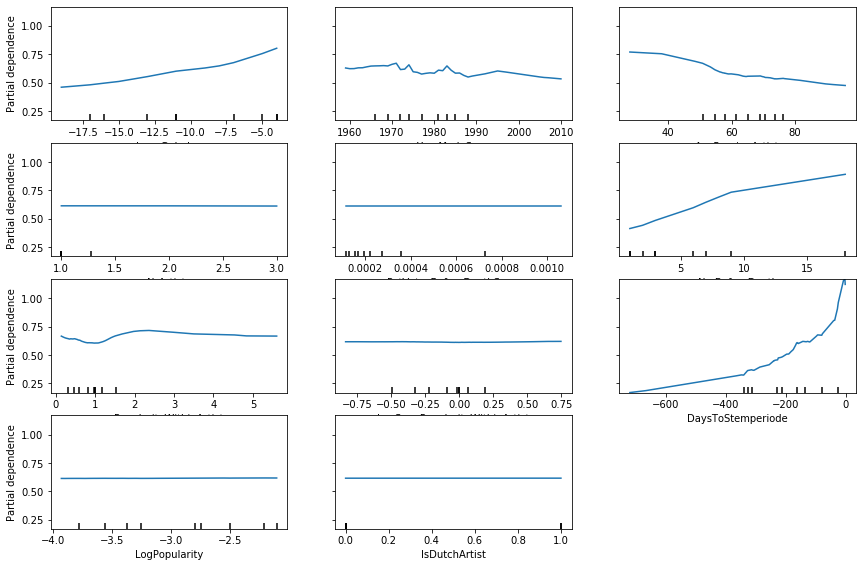

In [71]:
print(X_train.columns.tolist())
clf = tpot.fitted_pipeline_
fig, ax = plt.subplots(figsize=(12, 8))

disp = plot_partial_dependence(clf, X_train, X_train.columns, ax=ax)
plt.tight_layout()
# plt.show()

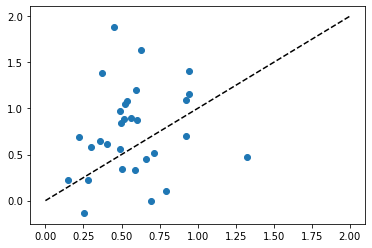

In [72]:
yhat = tpot.predict(X_test)
plt.scatter(yhat, y_test)
plt.plot([0, 2], [0, 2], 'k--')

In [73]:
tpot.score(X_train, y_train)

-0.07015587781771379

In [74]:
tpot.score(X_test, y_test)

-0.43006184357753285

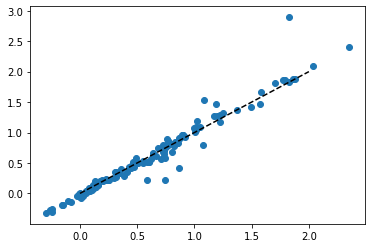

In [75]:
yhat = tpot.predict(X_train)
plt.scatter(yhat, y_train)
plt.plot([0, 2], [0, 2], 'k--')

## Basic Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
rf = RandomForestRegressor(max_depth=3)

In [78]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=3)

In [79]:
y_pred = rf.predict(X_test)
test_score_rf = sklearn.metrics.mean_absolute_error(y_test, y_pred)
display(test_score_rf)
model_results['RandomForest'] = test_score_rf

0.4636560830957434

## Single-level Bayesian model

In [32]:
RANDOM_SEED = 42

In [33]:
def unpooled_model_factory(X, y):
    coords = {"obs_id": np.arange(X.shape[0])}
    with pm.Model(coords=coords) as model:
        days_to_stemperiode = pm.Data('days_to_stemperiode', X['DaysToStemperiode'], dims='obs_id')
        logpopularity = pm.Data('logpopularity', X['LogPopularityNorm'], dims='obs_id')
        jaren_geleden = pm.Data("jaren_geleden", X['JarenGeleden'], dims='obs_id')
        passing_too_early = pm.Data('passing_too_early', X['PassingTooEarly'], dims='obs_id')
        is_dutch = pm.Data('is_dutch', X['IsDutchArtist'], dims='obs_id')

        multiple_performers = pm.Data('multiple_performers', X['MultiplePerformers'], dims="obs_id")
        popularity_within_oeuvre = pm.Data('popularity_within_oeuvre', X['LogSongPopularityWithinArtist'], dims="obs_id")

        # Hyperpriors:
        a = pm.Normal("a", mu=0, sigma=2.0)

        recency_effect_exponent = pm.Normal('recency_effect_exponent', mu=-1.5,sigma=1)
        max_recency_effect = pm.Normal('max_recency_effect', mu=2, sigma=2)
        effect_popularity = pm.Normal('effect_popularity', mu=0, sigma=2)
        history_effect = pm.Normal('history_effect', mu=0, sigma=1)
        age_passing_effect = pm.Normal('age_passing_effect', mu=0, sigma=1)
        is_dutch_effect = pm.Normal('is_dutch_effect', mu=0, sigma=2)

        # Expected value per artist:
        mu_artist = (a
                     + logpopularity * effect_popularity
                     # The correction of subtracting the minimum value is important for two reasons:
                     # 1. Since it fixes the minimum value at 1, it breaks the degeneracy with _a_, which makes sampling much more stable
                     # 2. It allows for much easier interpretation
                     + (np.exp(10**recency_effect_exponent * days_to_stemperiode)- np.exp(10**recency_effect_exponent * -365))* max_recency_effect
                     + jaren_geleden * history_effect
                     + passing_too_early * age_passing_effect
                     + is_dutch * is_dutch_effect
                    )

        sharing_effect = pm.Normal('sharing_effect', mu=0, sigma=2.0)
        within_oeuvre_effect = pm.Normal('within_oeuvre_effect', mu=0, sigma=2.0)
        theta = (mu_artist
                 + multiple_performers * sharing_effect
                 + popularity_within_oeuvre * within_oeuvre_effect
                )
        # Model error:
        sigma = pm.Exponential("sigma", 1.0)

        y_like = pm.Normal("y_like", theta, sigma=sigma, observed=y, dims="obs_id")

        return model

In [34]:
with unpooled_model_factory(X=df_train,
                   y=y_train,
                   ) as multilevel_noncentered_model:
#     display(pm.model_to_graphviz(multilevel_noncentered_model))
    unpooled_model_idata = pm.sample(5000, tune=3000, return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.95)

ExecutableNotFound: failed to execute ['dot.bat', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, within_oeuvre_effect, sharing_effect, is_dutch_effect, age_passing_effect, history_effect, effect_popularity, max_recency_effect, recency_effect_exponent, a]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 100 seconds.


0, dim: obs_id, 123 =? 123


In [35]:
with unpooled_model_factory(X=df_test,
                   y=y_test,
                   ) as test_model:
    ppc_unpooled = pm.fast_sample_posterior_predictive(unpooled_model_idata.posterior,
                                         var_names=['y_like'],
                                        )


In [36]:
y_pred_unpooled = np.median(ppc_unpooled['y_like'], axis=0)

In [37]:
pd.DataFrame(ppc_unpooled['y_like']).median().sub(y_test.values).abs().agg(['mean', 'sem'])

mean    0.377371
sem     0.053714
dtype: float64

In [38]:
model_results['Unpooled'] = sklearn.metrics.mean_absolute_error(y_test, y_pred_unpooled)

## Multi-level Bayesian model

In [39]:
import pymc3 as pm
import arviz as az

In [40]:
RANDOM_SEED = 42
def model_factory(X, y):
    passed_away_artists = X['ArtistID'].unique()
    artist_lookup = dict(zip(passed_away_artists, range(len(passed_away_artists))))
    artist_vals = X['ArtistID'].replace(artist_lookup).values
    artist_model = (X.assign(ArtistIDModel = lambda df: X['ArtistID'].map(artist_lookup),
                             )
                .sort_values('ArtistIDModel')
                .drop_duplicates(['ArtistIDModel'])
               )
    
    
    coords = {"obs_id": np.arange(X.shape[0]),
              'Artist': range(len(passed_away_artists))
         }
    with pm.Model(coords=coords) as model:
        artist_idx = pm.Data("artist_idx", artist_vals, dims="obs_id")
        days_to_stemperiode = pm.Data('days_to_stemperiode', artist_model['DaysToStemperiode'], dims='Artist')
        logpopularity = pm.Data('logpopularity', artist_model['LogPopularityNorm'], dims='Artist')
        jaren_geleden = pm.Data("jaren_geleden", artist_model['JarenGeleden'], dims='Artist')
        passing_too_early = pm.Data('passing_too_early', artist_model['PassingTooEarly'], dims='Artist')
        is_dutch = pm.Data('is_dutch', artist_model['IsDutchArtist'], dims='Artist')

        multiple_performers = pm.Data('multiple_performers', X['MultiplePerformers'], dims="obs_id")
        popularity_within_oeuvre = pm.Data('popularity_within_oeuvre', X['LogSongPopularityWithinArtist'], dims="obs_id")

        # Hyperpriors:
        a = pm.Normal("a", mu=0, sigma=2.0)
        sigma_a = pm.Exponential("sigma_a", 1.0)

        recency_effect_exponent = pm.Normal('recency_effect_exponent', mu=-1.5,sigma=1)
        max_recency_effect = pm.Normal('max_recency_effect', mu=2, sigma=2)
        effect_popularity = pm.Normal('effect_popularity', mu=0, sigma=2)
        history_effect = pm.Normal('history_effect', mu=0, sigma=1)
        age_passing_effect = pm.Normal('age_passing_effect', mu=0, sigma=1)
        is_dutch_effect = pm.Normal('is_dutch_effect', mu=0, sigma=2)

        # Expected value per artist:
        mu_artist = (a
                     + logpopularity * effect_popularity
                     # The correction of subtracting the minimum value is important for two reasons:
                     # 1. Since it fixes the minimum value at 1, it breaks the degeneracy with _a_, which makes sampling much more stable
                     # 2. It allows for much easier interpretation
                     + (np.exp(10**recency_effect_exponent * days_to_stemperiode)- np.exp(10**recency_effect_exponent * -365))* max_recency_effect
                     + jaren_geleden * history_effect
                     + passing_too_early * age_passing_effect
                     + is_dutch * is_dutch_effect
                    )

        # This is the non-centered version of the model for a much more stable sampling
        # See https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/ for more information
        mu_artist = pm.Deterministic("mu_artist", mu_artist, dims="Artist")
        za_artist = pm.Normal("za_artist", mu=0.0, sigma=1.0, dims='Artist')
        a_artist = pm.Deterministic("a_artist", mu_artist + za_artist * sigma_a, dims="Artist")
        sharing_effect = pm.Normal('sharing_effect', mu=0, sigma=2.0)
        within_oeuvre_effect = pm.Normal('within_oeuvre_effect', mu=0, sigma=2.0)
        theta = (a_artist[artist_idx]
                 + multiple_performers * sharing_effect
                 + popularity_within_oeuvre * within_oeuvre_effect
                )
        # Model error:
        sigma = pm.Exponential("sigma", 1.0)

        y_like = pm.Normal("y_like", theta, sigma=sigma, observed=y, dims="obs_id")

        return model

In [41]:
with model_factory(X=df_train,
                   y=y_train,
                   ) as multilevel_noncentered_model:
    display(pm.model_to_graphviz(multilevel_noncentered_model))
    multilevel_noncentered_model_idata = pm.sample(5000, tune=3000, return_inferencedata=True, random_seed=RANDOM_SEED, target_accept=0.95)

ExecutableNotFound: failed to execute ['dot.bat', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, within_oeuvre_effect, sharing_effect, za_artist, is_dutch_effect, age_passing_effect, history_effect, effect_popularity, max_recency_effect, recency_effect_exponent, sigma_a, a]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 130 seconds.


0, dim: obs_id, 123 =? 123


The number of effective samples is smaller than 25% for some parameters.


In [43]:
with model_factory(X=df_test,
                   y=y_test,
                   ) as test_model:
    # For newly passed artists, we do not know what za_artist should be
    ppc_multilevel = pm.sample_posterior_predictive(multilevel_noncentered_model_idata.posterior.drop_vars(['mu_artist', 'a_artist', 'za_artist']),
                                        )


In [44]:
az.concat(multilevel_noncentered_model_idata, az.from_dict(posterior_predictive=ppc_multilevel), inplace=True)

C:\Users\Gebruiker\anaconda3\envs\Top2000H\lib\site-packages\arviz\data\base.py:169: UserWarning: More chains (10000) than draws (30). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [45]:
np.abs(ppc_multilevel['y_like'].mean(axis=0) - y_test.values).mean()

0.3849525126991395

In [46]:
pd.DataFrame(ppc_multilevel['y_like']).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.738621,0.738075,0.536721,0.526180,0.691582,0.413990,0.693479,0.692607,0.690888,0.688549,...,0.823722,0.531315,0.270388,0.759456,0.175304,0.147152,0.981941,0.976806,0.700962,0.981412
std,0.503992,0.501150,0.467926,0.464597,0.469804,0.484305,0.465141,0.474002,0.467757,0.464712,...,0.475986,0.483317,0.462896,0.485971,0.468303,0.467800,0.495500,0.492966,0.508726,0.498884
min,-1.313374,-1.205216,-1.163036,-1.192103,-0.964179,-1.436090,-1.087546,-1.149214,-1.226663,-1.160701,...,-0.945018,-1.256891,-1.726694,-1.084681,-1.669123,-1.574411,-0.834448,-0.879441,-1.034938,-0.819648
25%,0.402915,0.399713,0.223944,0.214754,0.385273,0.091926,0.385896,0.376186,0.381111,0.380366,...,0.501730,0.204521,-0.042645,0.429908,-0.142434,-0.169326,0.648472,0.645026,0.353942,0.643121
50%,0.736949,0.734484,0.538486,0.526408,0.693961,0.414509,0.682014,0.695145,0.695137,0.693772,...,0.827557,0.523353,0.268066,0.768223,0.171761,0.148745,0.987655,0.976024,0.703722,0.976412
75%,1.075742,1.076594,0.846440,0.835581,1.003181,0.732684,1.002364,1.008041,1.002789,1.000403,...,1.147160,0.860457,0.585025,1.082361,0.490621,0.461210,1.309992,1.313891,1.043668,1.311321
max,3.065274,2.752201,2.213161,2.226504,2.784989,2.412201,2.830495,2.638455,2.444957,2.512138,...,2.600195,2.404328,2.657128,2.751508,1.965873,2.088943,2.978923,2.877209,3.220163,2.813467


In [47]:
y_pred_multilevel = np.median(ppc_multilevel['y_like'], axis=0)
sklearn.metrics.mean_absolute_error(y_test, y_pred_multilevel)

0.38513578789949793

In [48]:
model_results['Partially pooled'] = sklearn.metrics.mean_absolute_error(y_test, y_pred_multilevel)

# Visualization

In [80]:
model_results

{'TPOT': 0.43006184357753285,
 'RandomForest': 0.4636560830957434,
 'Unpooled': 0.3773713435519229,
 'Partially pooled': 0.38513578789949793}

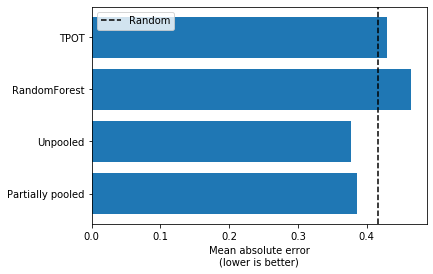

In [81]:
y_pos = range(len(model_results), 0, -1)
plt.barh(y_pos, list(model_results.values()))
plt.gca().set_yticks(y_pos)
plt.gca().set_yticklabels(labels=list(model_results.keys()))
plt.gca().axvline(DUMMY_SCORE, c='k', ls='--', label='Random')
plt.xlabel('Mean absolute error\n(lower is better)')
plt.legend()
plt.show()